In [315]:
import os
import pandas as pd
import seaborn as sns
import datetime as dt
import pathlib
import matplotlib.pyplot as plt
from collections import Counter
import urllib
import numpy as np
import plotly.express as ex

In [316]:
# Specify path to folder with data
my_path = '/Users/mjdelg/Desktop/tests/tiktok_scrape/data'
files = sorted(os.listdir(my_path))

def read_data():
    """
    Function reads all files in a folder and creates two dataframes: one
    for the control data and one for the active data. 
    """
    count1, count2 = 1, 1
    dataframes, dataframes2 = [], []
    for file in files:
        cur_path = my_path + '/' + file
        if 'csv' in file:
            # extract time and date of file creation
            path = pathlib.Path(cur_path)
            timestamp = path.stat().st_mtime
            my_time = dt.datetime.fromtimestamp(timestamp)
            # read in csv file into df
            df = pd.read_csv(cur_path)
            if "Cntrl" in file:
                dataframes.append(df)
                df['timegroup'] = count1
                count1 += 1
                df['Group'] = "Control"
            else:
                dataframes2.append(df)
                df['timegroup'] = count2
                count2 += 1
                df['Group'] = "Active"
            df['time'] = my_time
            
    control, active = pd.concat(dataframes), pd.concat(dataframes2)
    combined = pd.concat([control, active])
    combined.time = pd.to_datetime(combined.time)
    combined.time.dt.round('s')
    return control, active, combined

control, active, combined = read_data()

In [317]:
def plot_metric(var):
    """
    Plots a given metric over time with a regression line.
    Param: 
        var: string representing name of metric
    """
    pal = ["#F72585", "#4361EE"]
    var_name = var[0].upper() + var[1:]
    plot = sns.lineplot(x='timegroup', y=var, data = combined, hue = "Group", palette=pal)
    sns.regplot(x='timegroup', y=var,data=combined, scatter = None, ci=None, color="black")
    plt.xticks(rotation=45)
    plot.set(xlabel='Time',
       ylabel=f'Total {var_name}',
       title=f'{var_name} across Groups')
    plt.grid()
    plt.show()

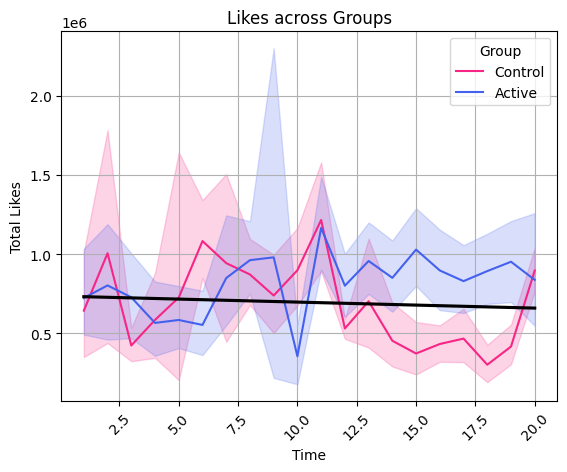

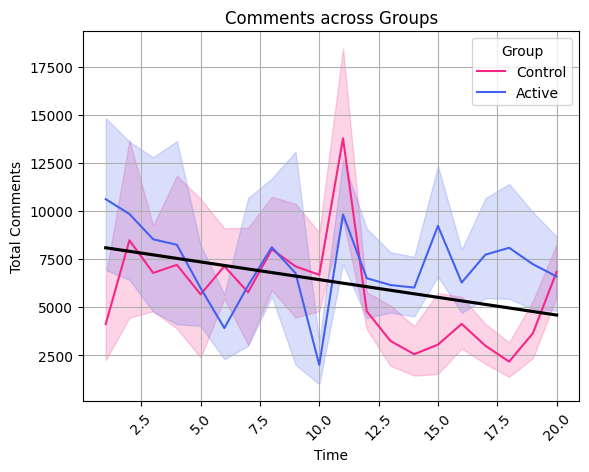

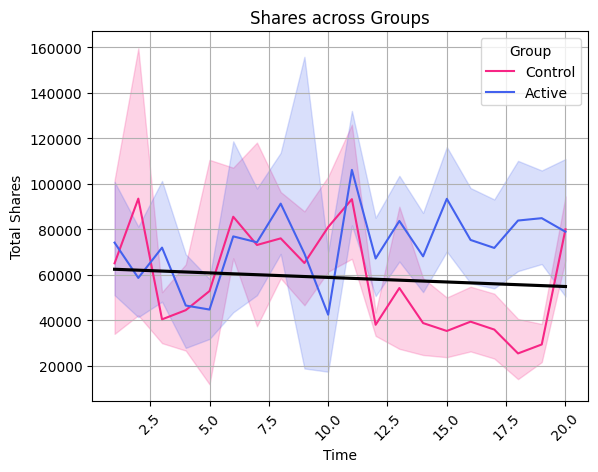

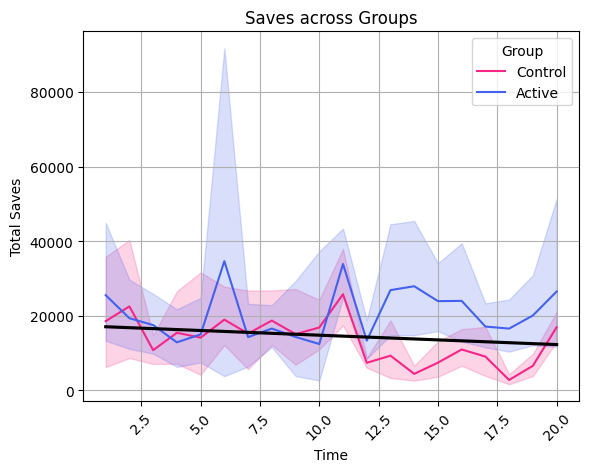

In [318]:
# Make plots
plot_metric('likes')
plot_metric('comments')
plot_metric('shares')
plot_metric('saves')

In [321]:

allHashtagsCnt = Counter() # global variable that will be changed through the helper function
control_hash = Counter()
act_hash = Counter()

def countAllHashtags(cell, mode = "all"):
    """
    Takes a string or a NaN value. Splits the srings to find hashtags, updates a Counter object
    (a global variable) to keep track of all hashtags.
    """
    if type(cell) == str: # avoid NaN values, which are float
        htList = [el.strip() for el in cell.split(',')] # prepare individual hashtags
        if mode == "all":
            allHashtagsCnt.update(htList) # method update of Counter takes a list and updates all keys
        elif mode == "control":
            control_hash.update(htList)
        elif mode == "active":
            act_hash.update(htList)

In [322]:
_ = combined['hashtag'].apply(countAllHashtags)
_ = control['hashtag'].apply(countAllHashtags, mode="control")
_ = active['hashtag'].apply(countAllHashtags, mode="active")

In [329]:
allHashtagsCnt.most_common(10)
#control_hash.most_common(10)
#act_hash.most_common(10)
#print(urllib.parse.unquote('fyp%E3%82%B7'))
#print(urllib.parse.unquote('fyp%E3%82%B7%E3%82%9Aviral'))

[('fyp', 1544),
 ('viral', 720),
 ('parati', 582),
 ('foryou', 554),
 ('fyp%E3%82%B7', 496),
 ('foryoupage', 323),
 ('tiktok', 197),
 ('trending', 154),
 ('funny', 152),
 ('humor', 120)]

In [325]:
def get_set(data):
    """
    Returns set of hashtags
    Params:
        data: pandas dataframe with all user data
    """
    all_hash= data['hashtag'].to_list()
    hashstr = ",".join(all_hash)
    hash_str = hashstr.split(',')
    return set(hash_str)

def get_intersec_hash(active, control):
    """
    Returns set with intersection of hashtags in
    active and control datasets
    Params:
        active: pandas dataframe with active user data
        control: pandas dataframe with control user data
    """
    active_hash = get_set(active)
    control_hash = get_set(control)
    return active_hash.intersection(control_hash)

def jaccard_index(data, active, control):
    """
    Returns jaccard index = intersection/union
    Params:
        data: pandas dataframe with all user data
        active: pandas dataframe with active user data
        control: pandas dataframe with control user data
    """
    union = len(get_set(data))
    intersec = len(get_intersec_hash(active, control))
    return round(intersec/union,3)

In [327]:
def get_jac_over_time(data):
    """
    Returns a list
    Params:
        data: pandas dataframe with all user data
    """
    jac_index = []
    data_by_time = data.groupby('timegroup')
    data_by_group_time = data.groupby(['Group', 'timegroup'])
    for i in range(1, 21):
        cur_control = data_by_group_time.get_group(('Control', i))
        cur_act = data_by_group_time.get_group(('Active', i))
        complete_group = data_by_time.get_group(i)
        cur_jac = jaccard_index(complete_group, cur_act, cur_control)
        jac_index.append(cur_jac)
    return jac_index

def plot_jac_over_time(jac_list):
    """
    Plots the evolution of the jaccard index over time
    Params:
        jac_list: list of jaccard indices
    """
    plot = sns.lineplot(x=list(range(1,21)), y = jac_list)
    plot.set(xlabel='Time',
       ylabel=f'Jaccard Index',
       title=f'Jaccard Index Across Batches of Collected Data')
    plt.grid()
    plt.show()


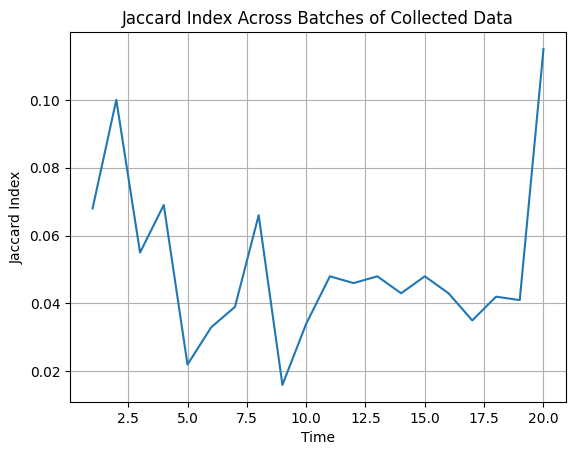

In [328]:
combined_hash = combined.dropna(subset='hashtag')
jac_index = get_jac_over_time(combined_hash)
plot_jac_over_time(jac_index)

In [332]:
# Jaccard Index For All Data
act = active.dropna(subset='hashtag')
con = control.dropna(subset='hashtag')
total_jac = jaccard_index(combined_hash, act, con)
total_jac

0.153

In [330]:
combined['music_count'] = combined['music'].map(control['music'].value_counts())
c_music = combined.sort_values('music_count', ascending=False).drop_duplicates(subset='music').head(5)
top_sounds = ex.bar(c_music, x="music", y = "music_count", labels={
                     "music": "Music Sounds",
                     "music_count": "Total Counts"
                 },
                title="Top five sounds")
top_sounds